In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [2]:
df = pd.read_csv("cs-training.csv")
df.drop(columns=["Unnamed: 0"], inplace=True)  # drop index column

In [3]:
print("Initial shape:", df.shape)
print(df.head())
print("\nMissing values:\n", df.isnull().sum())

Initial shape: (150000, 11)
   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 1                              0.766127   45   
1                 0                              0.957151   40   
2                 0                              0.658180   38   
3                 0                              0.233810   30   
4                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4

In [4]:
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)


C:\Users\Welcome\AppData\Local\Temp\ipykernel_11316\2604866267.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
C:\Users\Welcome\AppData\Local\Temp\ipykernel_11316\2604866267.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

In [5]:
df["IncomeDebtRatio"] = df["MonthlyIncome"] / (df["DebtRatio"] + 1)

In [6]:
df = df[(df['age'] >= 18) & (df['age'] <= 100)]
df["RevolvingUtilizationOfUnsecuredLines"] = df["RevolvingUtilizationOfUnsecuredLines"].clip(0, 1)

In [7]:
target = "SeriousDlqin2yrs"
features = [
    "RevolvingUtilizationOfUnsecuredLines",
    "age",
    "NumberOfTime30-59DaysPastDueNotWorse",
    "DebtRatio",
    "MonthlyIncome",
    "NumberOfOpenCreditLinesAndLoans",
    "NumberOfTimes90DaysLate",
    "NumberRealEstateLoansOrLines",
    "NumberOfTime60-89DaysPastDueNotWorse",
    "NumberOfDependents",
    "IncomeDebtRatio"
]

X = df[features]
y = df[target]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
def evaluate_model(name, model, X_train, X_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n===== {name} =====")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")



===== Logistic Regression =====
Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     27993
           1       0.65      0.05      0.09      2005

    accuracy                           0.93     29998
   macro avg       0.80      0.52      0.53     29998
weighted avg       0.92      0.93      0.91     29998

Confusion Matrix:
[[27939    54]
 [ 1903   102]]
ROC-AUC Score: 0.813843102742198

===== Decision Tree =====
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27993
           1       0.58      0.17      0.26      2005

    accuracy                           0.94     29998
   macro avg       0.76      0.58      0.61     29998
weighted avg       0.92      0.94      0.92     29998

Confusion Matrix:
[[27753   240]
 [ 1669   336]]
ROC-AUC Score: 0.8497840081680555

===== Random Forest =====
Classification Report:
              precision  

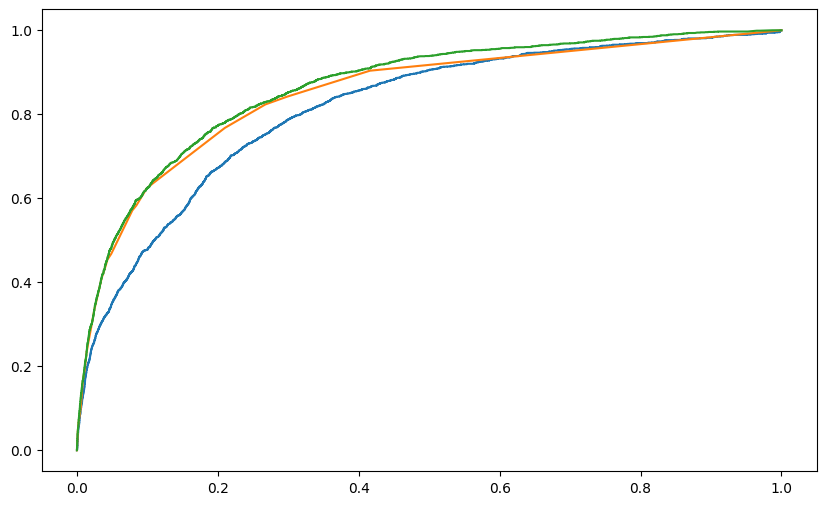

In [11]:
plt.figure(figsize=(10, 6))

# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
evaluate_model("Logistic Regression", lr_model, X_train_scaled, X_test_scaled)

# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
evaluate_model("Decision Tree", dt_model, X_train, X_test)

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
evaluate_model("Random Forest", rf_model, X_train, X_test)

C:\Users\Welcome\AppData\Local\Temp\ipykernel_11316\236624075.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


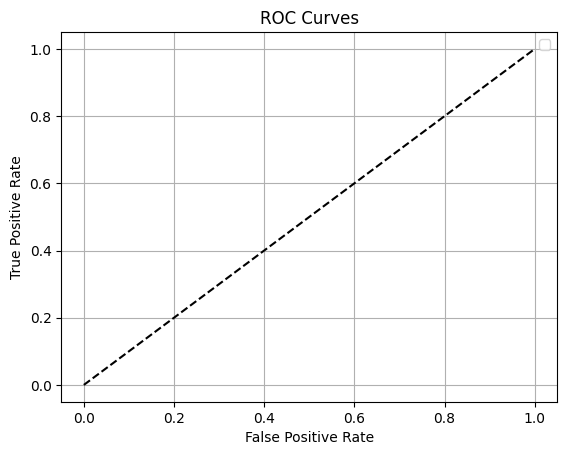

In [12]:
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
